In [1]:
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf

In [2]:
TICKER = '^GSPC'
df = yf.download(TICKER, start='1950-01-01')
df['Date'] = df.index
df = df[['Date', 'Open', 'Close', 'Adj Close']]
df.rename(columns={'Adj Close': 'Value'}, inplace=True)
df.index = range(df.shape[0])
df.tail()

[*********************100%***********************]  1 of 1 completed


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,Date,Open,Close,Value
18050,2021-10-15,4447.689941,4471.370117,4471.370117
18051,2021-10-18,4463.720215,4486.459961,4486.459961
18052,2021-10-19,4497.339844,4519.629883,4519.629883
18053,2021-10-20,4524.419922,4536.189941,4536.189941
18054,2021-10-21,4532.240234,4549.779785,4549.779785


In [3]:
if df.Open.min() == 0:
    for i in range(1, df.shape[0]):
        if df.loc[i, 'Open'] == 0:
            df.loc[i, 'Open'] = df.loc[i - 1, 'Close']
            
df.Open.min(), df.Close.min()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


(16.65999984741211, 16.65999984741211)

In [4]:
df['IntradayChange'] = df['Close'] / df['Open']
df['DayToDayChange'] = np.nan
df['OvernightChange'] = np.nan
for day in range(1, df.shape[0]):
    df.loc[day, 'DayToDayChange'] = (df.loc[day, 'Value'] 
                                     / df.loc[day - 1, 'Value'])
    df.loc[day, 'OvernightChange'] = (df.loc[day, 'Open'] 
                                      / df.loc[day - 1, 'Close'])
df.tail()

/var/folders/41/jhvt_zmd3nz3x5jsqblr221r0000gn/T/ipykernel_87686/620658147.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['IntradayChange'] = df['Close'] / df['Open']
/var/folders/41/jhvt_zmd3nz3x5jsqblr221r0000gn/T/ipykernel_87686/620658147.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['DayToDayChange'] = np.nan


,Date,Open,Close,Value,IntradayChange,DayToDayChange,OvernightChange
18050,2021-10-15,4447.689941,4471.370117,4471.370117,1.005324,1.007460,1.002125
18051,2021-10-18,4463.720215,4486.459961,4486.459961,1.005094,1.003375,0.998289
18052,2021-10-19,4497.339844,4519.629883,4519.629883,1.004956,1.007393,1.002425
18053,2021-10-20,4524.419922,4536.189941,4536.189941,1.002601,1.003664,1.001060
18054,2021-10-21,4532.240234,4549.779785,4549.779785,1.003870,1.002996,0.999129


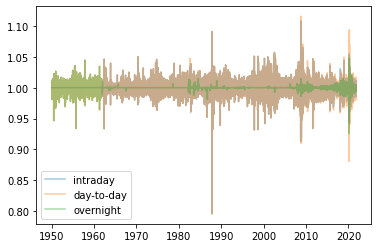

In [5]:
plt.plot(df.Date, df.IntradayChange, alpha=0.4, label='intraday')
plt.plot(df.Date, df.DayToDayChange, alpha=0.4, label='day-to-day')
plt.plot(df.Date, df.OvernightChange, alpha=0.4, label='overnight')
plt.legend();

In [6]:
START_DATE = df.loc[0,  'Date']
print(START_DATE)
df['LogValue'] = np.log(df.Value)
df.tail()

1950-01-03 00:00:00


,Date,Open,Close,Value,IntradayChange,DayToDayChange,OvernightChange,LogValue
18050,2021-10-15,4447.689941,4471.370117,4471.370117,1.005324,1.007460,1.002125,8.405450
18051,2021-10-18,4463.720215,4486.459961,4486.459961,1.005094,1.003375,0.998289,8.408819
18052,2021-10-19,4497.339844,4519.629883,4519.629883,1.004956,1.007393,1.002425,8.416185
18053,2021-10-20,4524.419922,4536.189941,4536.189941,1.002601,1.003664,1.001060,8.419843
18054,2021-10-21,4532.240234,4549.779785,4549.779785,1.003870,1.002996,0.999129,8.422834


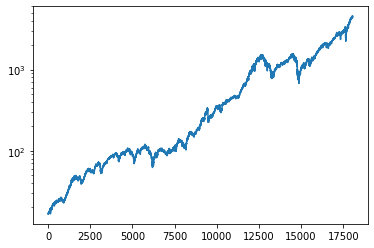

In [7]:
plt.plot(df.Value)
plt.yscale('log');

In [8]:
df.index = df.Date
TODAY = datetime.now().date()
TODAY

datetime.date(2021, 10, 21)

In [9]:
def get_macd(
        prices, fast=75, slow=155, sig=35, dirline=70, plot=False, 
        daterange=None):
    n = len(prices)
    ema_fast = prices.ewm(span=fast).mean()
    ema_slow = prices.ewm(span=slow).mean()
    macd = ema_fast - ema_slow
    signal = macd.ewm(span=sig).mean()
    histo = macd - signal
    direction = histo.copy().tolist()
    direction[0] = 0
    for i in range(1, n):
        direction[i] = 1 * (histo[i] > histo[i - 1])
    direction = pd.Series(direction, index=histo.index)
    if plot:
        plt.figure()
        plt.plot(macd, 'k-', label='macd')
        plt.plot(signal, 'r-', label='signal')
        plt.plot(histo, 'b-', label='histo')
        plt.axhline(0, color='grey')
        plt.plot(direction * dirline, color='#008800', alpha=0.6)
        plt.legend()
    if daterange is not None:
        plt.xlim([pd.to_datetime(x) for x in daterange])
    if plot:
        plt.show()
    df = pd.DataFrame({'histo': histo, 'direction': direction})
    df.index = range(n)
    df['Actions'] = 'none'
    for i in range(2, df.shape[0]):
        last_two = tuple(df.loc[i - 2:i - 1, 'direction'])
        df.loc[i, 'Actions'] = {
            (0, 0): 'none',
            (0, 1): 'buy',
            (1, 0): 'sell',
            (1, 1): 'hold'
        }[last_two]
    df.index = prices.index
    return df

In [10]:
#test = get_macd(
#    df.Value, 60, 90, 80, plot=True, daterange=['2020-01-01', TODAY])
#test.head()

In [11]:
def hist_model(hist, data):
    df = pd.concat([data.copy(), hist], axis=1)
    n = df.shape[0]
    df.index = range(n)
    df['Model'] = 1
    for i in range(1, n):
        row = df.loc[i, :]
        action = row.Actions
        multiplier = {
            'none': 1,
            'buy': row.IntradayChange,
            'hold': row.DayToDayChange,
            'sell': row.OvernightChange
        }[action]
        df.loc[i, 'Model'] = df.loc[i - 1, 'Model'] * multiplier
    return df

In [12]:
def run_test(params, df, plot=True, lim=0):
    data = df.copy()
    fast, slow, signal = params
    macd_histo = get_macd(data.Value, 
                          fast=fast, 
                          slow=slow, 
                          sig=signal, 
                          plot=False)
    mod_df = hist_model(macd_histo, data)
    result = mod_df.Model[mod_df.index.max()]
    if plot and result > lim:
        plt.figure(figsize=(12, 6))
        plt.plot(mod_df.Model, label='model')
        plt.plot(mod_df.Value / mod_df.loc[mod_df.index.min(), 'Value'],
                 label='market')
        plt.yscale('log')
        plt.legend()
        plt.show()
    return result

In [15]:
BEST_RESULT = 0
BEST_PARAMS = [5, 10, 10]

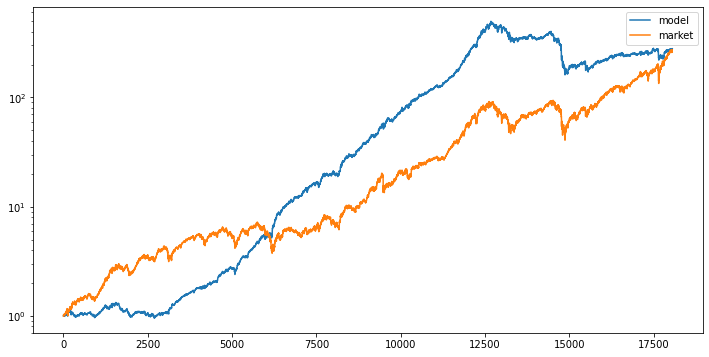

New Best Result: 279.5848833871281
Params:
  fast: 5
  slow: 10
  signal: 5
Update BEST values.


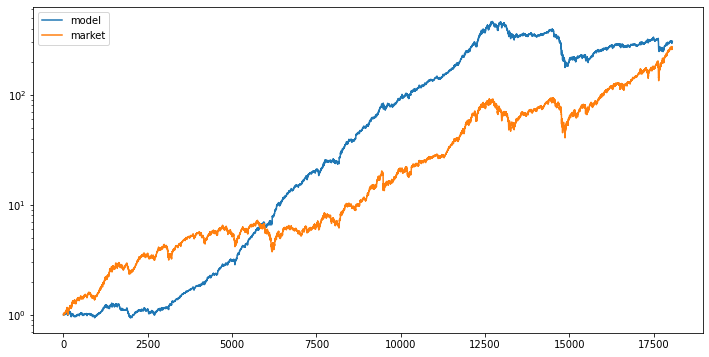

New Best Result: 307.86700750847746
Params:
  fast: 5
  slow: 40
  signal: 5
Update BEST values.


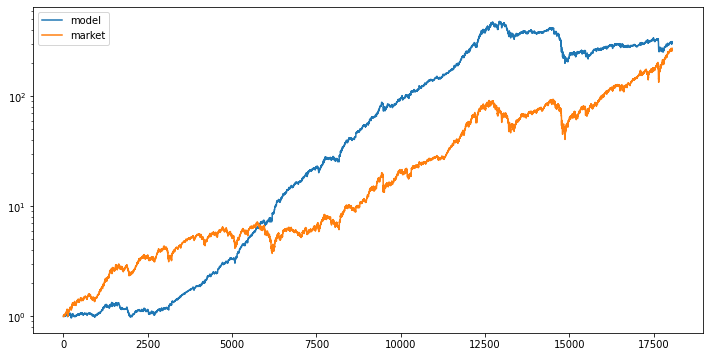

New Best Result: 313.8568321432586
Params:
  fast: 5
  slow: 80
  signal: 5
Update BEST values.
Current best: 313.8568321432586160)
Current best params: [5, 80, 5]


In [16]:
best_result = BEST_RESULT
best_params = BEST_PARAMS
param_set = [5, 10, 20, 40, 80, 160]
for fast in param_set:
    for slow in param_set:
        for signal in param_set:
            if fast == slow:
                continue
            print(f'Running with params: ({fast}, {slow}, {signal})', 
                  end='\r')
            params = [fast, slow, signal]
            result = run_test(params, df, lim=best_result)
            if result > best_result:
                print('New Best Result:', result)
                print(f'Params:\n  fast: {fast}\n  slow: {slow}\n'
                      f'  signal: {signal}')
                print('Update BEST values.')
                best_result = result
                best_params = params
print('Current best:', best_result)
print('Current best params:', best_params) 

# Recent Data Only

In [17]:
recent = df.loc[df.Date >= pd.to_datetime('1995-01-01'), :]
recent.head()

,Date,Open,Close,Value,IntradayChange,DayToDayChange,OvernightChange,LogValue
Date,,,,,,,,
1995-01-03,1995-01-03,459.209991,459.109985,459.109985,0.999782,0.999652,0.999869,6.129290
1995-01-04,1995-01-04,459.130005,460.709991,460.709991,1.003441,1.003485,1.000044,6.132769
1995-01-05,1995-01-05,460.730011,460.339996,460.339996,0.999153,0.999197,1.000043,6.131965
1995-01-06,1995-01-06,460.380005,460.679993,460.679993,1.000652,1.000739,1.000087,6.132704
1995-01-09,1995-01-09,460.670013,460.829987,460.829987,1.000347,1.000326,0.999978,6.133029


In [18]:
#     Current best: 11.929100006695842
#     Current best params: [50, 3, 120]

BEST_RESULT = 0 #311.929100006695842
BEST_PARAMS = [50, 3, 120]

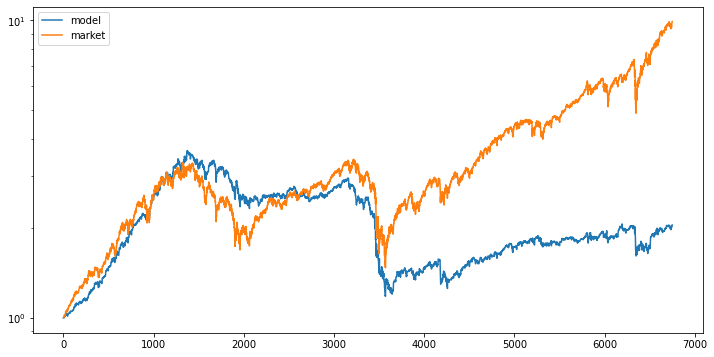

New Best Result: 2.0517054642295514
Params:
  fast: 5
  slow: 10
  signal: 5
Update BEST values.


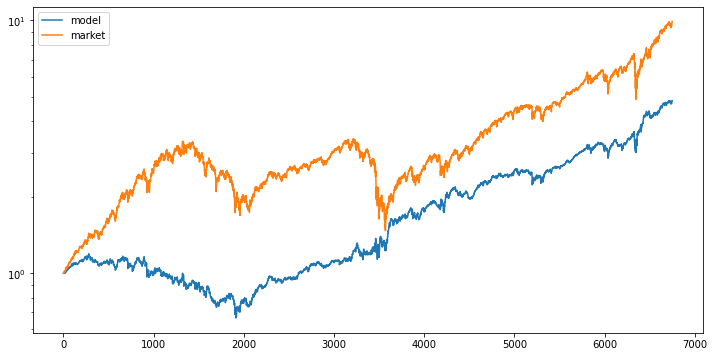

New Best Result: 4.813144048337795
Params:
  fast: 10
  slow: 5
  signal: 5
Update BEST values.


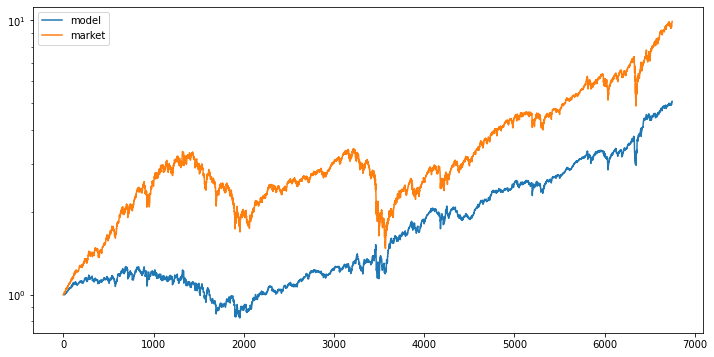

New Best Result: 5.06493795869589
Params:
  fast: 10
  slow: 5
  signal: 10
Update BEST values.


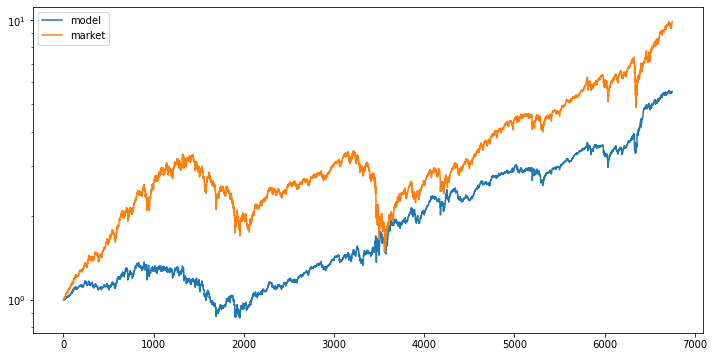

New Best Result: 5.561435284308776
Params:
  fast: 10
  slow: 5
  signal: 20
Update BEST values.


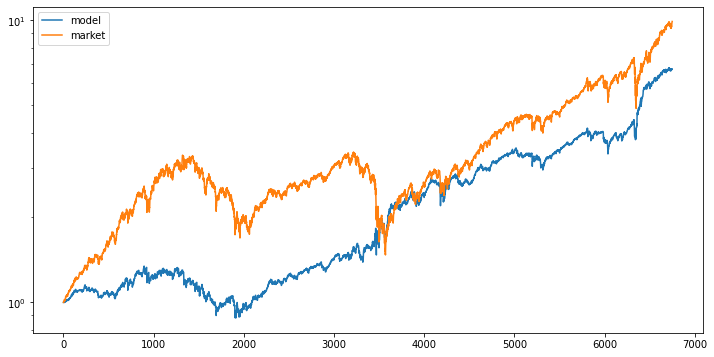

New Best Result: 6.726876977671392
Params:
  fast: 10
  slow: 5
  signal: 40
Update BEST values.


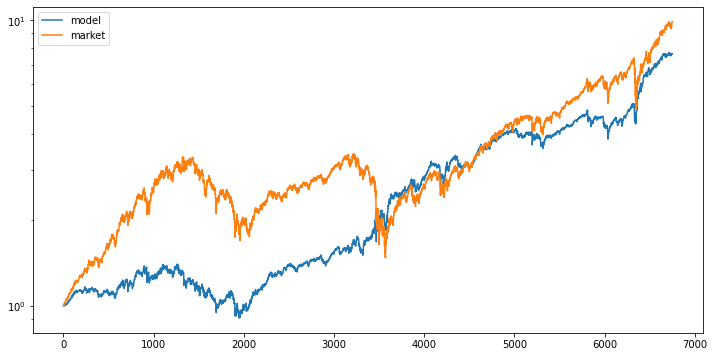

New Best Result: 7.644376134689639
Params:
  fast: 10
  slow: 5
  signal: 80
Update BEST values.


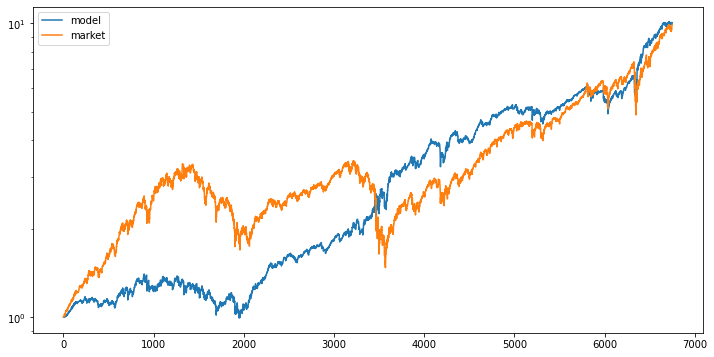

New Best Result: 10.039033152432333
Params:
  fast: 10
  slow: 5
  signal: 160
Update BEST values.


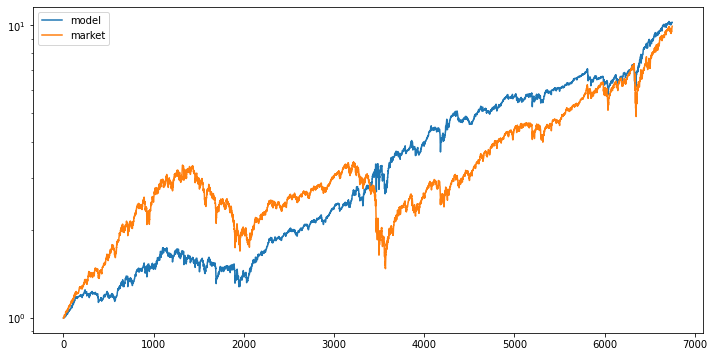

New Best Result: 10.214755840393904
Params:
  fast: 40
  slow: 5
  signal: 40
Update BEST values.


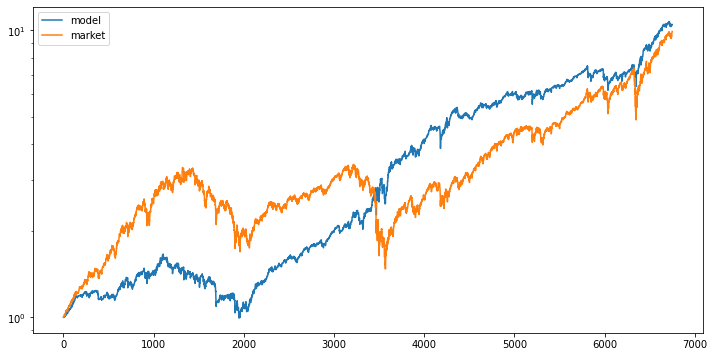

New Best Result: 10.470392674712715
Params:
  fast: 40
  slow: 5
  signal: 80
Update BEST values.
New Best Result: 10.470392674712715
Params:
  fast: 80
  slow: 5
  signal: 40
Update BEST values.
#     Current best: 10.470392674712715
#     Current best params: [80, 5, 40]


In [20]:
best_result = BEST_RESULT
best_params = BEST_PARAMS

for fast in [5, 10, 20, 40, 80, 160]:
    for slow in [5, 10, 20, 40, 80, 160]:
        for signal in [5, 10, 20, 40, 80, 160]:
            if fast == slow:
                continue
            print(f'Running with params: ({fast}, {slow}, {signal})', 
                  end='\r')
            params = [fast, slow, signal]
            result = run_test(params, recent, lim=best_result)
            if result >= best_result:
                print('New Best Result:', result)
                print(f'Params:\n  fast: {fast}\n  slow: {slow}\n'
                      f'  signal: {signal}')
                print('Update BEST values.')
                best_result = result
                best_params = params
print('#     Current best:', best_result)
print('#     Current best params:', best_params) 

In [107]:
!say all done! --voice=Lekha

# Last Decade Only

In [21]:
recent = df.loc[df.Date >= pd.to_datetime('2011-01-01'), :]
recent.head()

,Date,Open,Close,Value,IntradayChange,DayToDayChange,OvernightChange,LogValue
Date,,,,,,,,
2011-01-03,2011-01-03,1257.619995,1271.869995,1271.869995,1.011331,1.011315,0.999984,7.148244
2011-01-04,2011-01-04,1272.949951,1270.199951,1270.199951,0.997840,0.998687,1.000849,7.146930
2011-01-05,2011-01-05,1268.780029,1276.560059,1276.560059,1.006132,1.005007,0.998882,7.151924
2011-01-06,2011-01-06,1276.290039,1273.849976,1273.849976,0.998088,0.997877,0.999788,7.149799
2011-01-07,2011-01-07,1274.410034,1271.500000,1271.500000,0.997717,0.998155,1.000440,7.147953


In [27]:
#     BEST_RESULT = 3.115028874962549
#     BEST_PARAMS = [70, 10, 3]
BEST_RESULT = 3.115028874962549
BEST_PARAMS = [71, 10, 3]

In [30]:
best_result = BEST_RESULT
best_params = BEST_PARAMS

for fast in [69, 70, 71, 72, 73]:
    for slow in [8, 9, 10, 11, 12]:
        for signal in [2, 3, 4, 5]:
            if fast == slow:
                continue
            print(f'Running with params: ({fast}, {slow}, {signal})', 
                  end='\r')
            params = [fast, slow, signal]
            result = run_test(params, recent, lim=best_result)
            if result >= best_result:
                print('New Best Result:', result)
                print(f'Params:\n  fast: {fast}\n  slow: {slow}\n'
                      f'  signal: {signal}')
                print('Update BEST values.')
                best_result = result
                best_params = params
print('#     BEST_RESULT =', best_result)
print('#     BEST_PARAMS =', best_params) 

New Best Result: 3.115028874962549
Params:
  fast: 69
  slow: 10
  signal: 3
Update BEST values.
New Best Result: 3.115028874962549
Params:
  fast: 70
  slow: 10
  signal: 3
Update BEST values.
New Best Result: 3.115028874962549
Params:
  fast: 71
  slow: 10
  signal: 3
Update BEST values.
#     BEST_RESULT = 3.115028874962549
#     BEST_PARAMS = [71, 10, 3]
